 #### Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

#### Loading data

In [2]:
train = pd.read_csv('DailyDelhiClimateTrain.csv')
test = pd.read_csv('DailyDelhiClimateTest.csv')

In [3]:
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
print(f'train.shape: {train.shape}\ntest.shape: {test.shape}')

train.shape: (1462, 5)
test.shape: (114, 5)


#### Preprocessing

In [5]:
def preprocess_data(data_):
    X = data_.copy()
    X['date'] = pd.to_datetime(X['date'])
    y = X['meantemp']

    X['month'] = X['date'].dt.month
    X['quarter'] = X['date'].dt.quarter
    X['day_of_year'] = X['date'].dt.day_of_year

    feature_names = ['month', 'quarter', 'day_of_year']
    X = X[feature_names]
    
    return X, y

In [6]:
X_train, y_train = preprocess_data(train)
X_test, y_test = preprocess_data(test)
X_train.head()

,month,quarter,day_of_year
0,1,1,1
1,1,1,2
2,1,1,3
3,1,1,4
4,1,1,5


#### Training the model

In [7]:
param_grid = {'depth': [3, 4, 5, 6],
              'learning_rate': [0.01, 0.05, 0.1],
              'n_estimators': [20, 25, 30, 40]}
cat_boost = GridSearchCV(CatBoostRegressor(silent=True), param_grid)

# fitting
cat_boost.fit(X_train, y_train)


GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7fe3c8275190>,
             param_grid={'depth': [3, 4, 5, 6],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [20, 25, 30, 40]})

In [8]:
cat_boost.best_params_

{'depth': 4, 'learning_rate': 0.1, 'n_estimators': 40}

#### Predictions

In [9]:
test_pred = cat_boost.predict(X_test)
train_pred = cat_boost.predict(X_train)

In [10]:
print(f'TRAIN: MAE = {round(mean_absolute_error(y_train, train_pred), 3)}')
print(f' TEST: MAE = {round(mean_absolute_error(y_test, test_pred), 3)}')

TRAIN: MAE = 1.852
 TEST: MAE = 2.295


#### Visualization

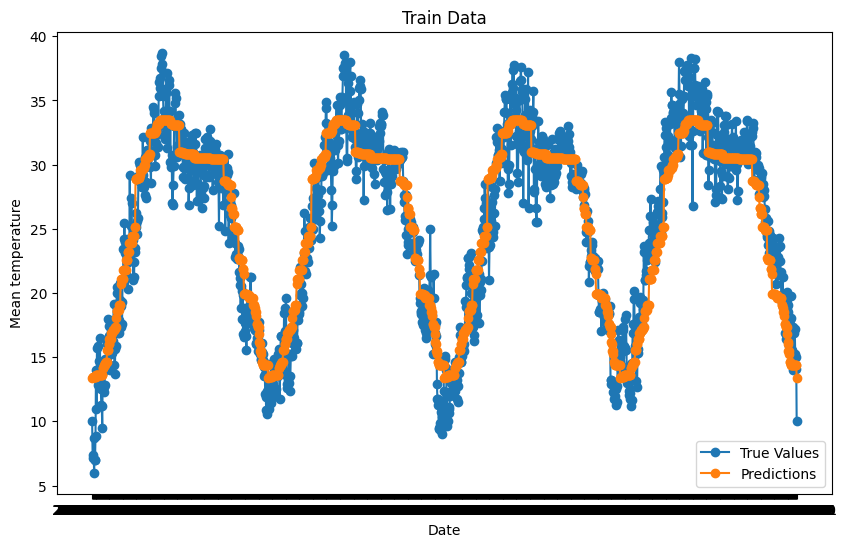

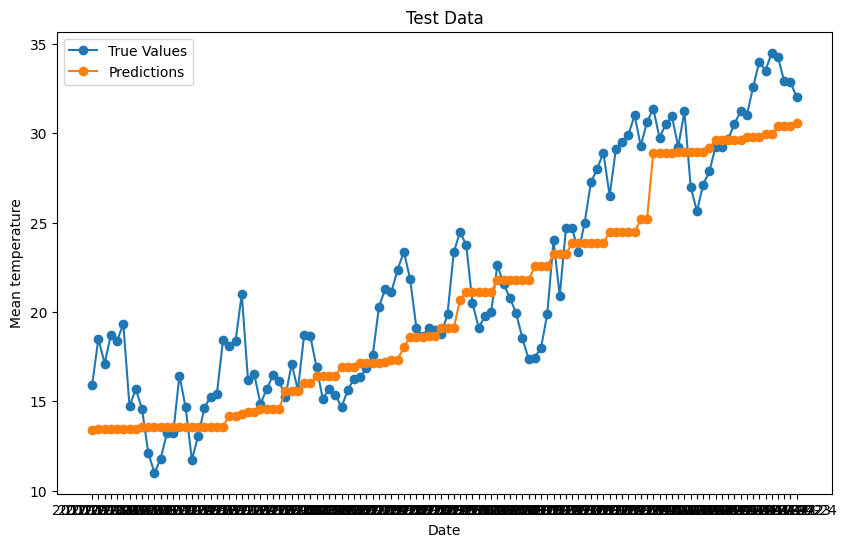

In [11]:
def plot_predictions(period, pred, y_true, label):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(period, y_true, label='True Values', marker='o')
    plt.plot(period, pred, label='Predictions', marker='o')

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Mean temperature')
    plt.title(label)

    # Adding legend
    plt.legend()

    # Show the plot
    plt.show()

plot_predictions(train['date'], train_pred, y_train, 'Train Data')
plot_predictions(test['date'], test_pred, y_test, 'Test Data')


#### Feature Importance

In [12]:
feature_importances = cat_boost.best_estimator_.get_feature_importance().round(3)
dict(zip(X_train.columns, feature_importances))

{'month': 20.799, 'quarter': 15.404, 'day_of_year': 63.798}

#### Future predictions

In [13]:
from datetime import datetime, timedelta

def preprocess_future_data(data): # return X
    data['date'] = pd.to_datetime(data['date'])
    data['month'] = data['date'].dt.month
    data['day_of_year'] = data['date'].dt.day_of_year
    data['quarter'] = data['date'].dt.quarter
    X = data[['month', 'day_of_year', 'quarter']]
    return X

# Define the start and end dates
start_date = datetime(2023, 12, 1)
end_date = datetime(2023, 12, 3)

# Generate a list of dates from start_date to end_date
date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

# Create a DataFrame with a date column
future_data = pd.DataFrame({'date': date_range})
preprocess_future_data(future_data)
future_data

,date,month,day_of_year,quarter
0,2023-12-01,12,335,4
1,2023-12-02,12,336,4
2,2023-12-03,12,337,4


In [14]:
future_pred = cat_boost.predict(future_data)

In [15]:
future_pred

array([19.08960443, 19.08960443, 19.08960443])

<br>

<br>

<br>

<br>

<br>

<br>

## What is next?

1. Find more historical data (consider the impact of global warming).

2. Adjust model parameters.

3. Generate additional features. For instance, incorporate data from 
the previous N days.<br>
When predicting tomorrow's weather, leveraging information,<br>
from today and the past N days can be particularly useful.